In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 21:14:48 2017

@author: Travis

"""

import os, gdal, time, inspect, shutil, pickle, glob, urllib, linecache, sys
import datetime
from datetime import timedelta
from itertools import chain
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import style
matplotlib.use('Qt5Agg')
import numpy as np
import numpy.ma as ma
import pandas as pd
#from scipy import stat
import inspect
from osgeo import ogr, osr
from tqdm import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from selenium import webdriver
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))

gdal.UseExceptions()
print("GDAL version:" + str(int(gdal.VersionInfo('VERSION_NUM'))))
#os.chdir('f:\\data\\droughtindices\\')
os.chdir('C:\\Users\\Travis\\GitHub\\Pasture-Rangeland-Forage\\')

###########################################################################
############## Function to readjust index intervals #######################
###########################################################################       
def adjustIntervals(indexlist):
    '''
        Takes in a list of monthly arrays (['index_yyyymm',array]) 
        Outputs a list of overlapping bimonthly arrays
            Simply averages each overlapping two month pair within each year. You have to do 
            this by year because Dec - Jan is not an interval, it starts over. This uses 
            bilinear resampling.
    '''
    # This is for the plot titles later
    indexnames = [array[0] for array in indexlist]

    # Find year range from available indices
    years = [indexnames[i][-6:-2] for i in range(len(indexnames))]
    year1 = min(years)
    year2 = max(years)
    
    # Create a function for individual years
    def adjustYear(year):
        indexyear = [index for index in indexlist if index[0][-6:-2] == year]
        newintervals = [[indexyear[i][0],(indexyear[i][1]+indexyear[i+1][1])/2] for i in range(len(indexyear)-1)]
        return(newintervals)

    # Use the above function to loop through each year and adjust intervals
    newyears = [adjustYear(str(year)) for year in range(int(year1),int(year2)+1)]
    
    # Flatten the above list of lists. (It's a list with yearly lists of 11 intervals now)
    newindex = [interval for year in newyears for interval in year]
    
    # This becomes the index that we calculate payouts on
    return(newindex)

###########################################################################
##################### Quick Histograms ####################################
###########################################################################    
def indexHist(array,guarantee = 1,mostfreq = 'n',binumber = 100, limmax = 0, sl = 0):
    '''
    array = single array or list of arrays
    '''
    
    # Check if it is a list with names, a list without names, a single array with a name, 
        # or a single array without a name.
    if type(array) == list:
        if type(array[0][0]) == str and len(array[0])==2:
            name = array[0][0][:-7] + ' Value Distribution'
            array = [ray[1] for ray in array]
            na = array[0][0,0]    
            for ray in array:
                ray[ray == na] = np.nan
        elif type(array[0]) == str:
            name = array[0] + ' Value Distribution'
            array = array[1]
            na = array[0,0]    
            array[array == na] = np.nan
        else:
            na = array[0][0,0]
            name = "Value Distribution"
            for ray in array:
                ray[ray == na] = np.nan
    else:
        na = array[0,0]
        name = "Value Distribution"
        array[array == na] = np.nan
    
    # Mask the array for the histogram (Makes this easier)
    arrays = np.ma.masked_invalid(array)
    
    # Get min and maximum values
    amin = np.min(arrays)
    printmax = np.max(arrays)
    if limmax > 0:
        amax = limmax
    else:
        amax = np.max(arrays)
        
    # Get the bin width, and the frequency of values within, set some
    # graphical parameters and then plot!
    fig = plt.figure(figsize=(8, 8))
    hists,bins = np.histogram(arrays,range = [amin,amax],bins = binumber,normed = True)
    if mostfreq != 'n':
        mostfreq =  float(bins[np.where(hists == np.max(hists))])
        targetbin = mostfreq
        targethist = np.max(hists)
        firstprint = 'Most Frequent Value: '+ str(round(mostfreq,2))    
    # Get bin of optional second line
    if sl != 0:     
        differences = [abs(bins[i] - sl) for i in range(len(bins))]
        slindex = np.where(differences == np.nanmin(differences))
        secondline = bins[slindex]
        slheight = hists[slindex]
        secondtitle = '\nRMA Strike level: ' + str(guarantee) + ', Alt Strike Level: ' + str(round(sl,4))
    else:
        secondtitle = ''
    if mostfreq != 'n':
        if mostfreq == 0:
            secondcheck = np.copy(hists)
            seconds = secondcheck.flatten()
            seconds.sort() 
            second = float(bins[np.where(hists == seconds[-2])])
            targetbin = second
            targethist= seconds[-2]
            secondprint = '\n       Second most Frequent: '+str(round(second,2))
        else:
            secondprint = '' 
    width = .65 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    title=(name+":\nMinimum: "+str(round(amin,2))+"\nMaximum: "+str(round(printmax,2))+secondtitle)
    plt.title(title,loc = 'center')    
    if mostfreq != 'n':
        plt.axvline(targetbin, color='black', linestyle='solid', linewidth=4)
        plt.axvline(targetbin, color='r', linestyle='solid', linewidth=1.5)
    drange = np.nanmax(arrays) - np.nanmin(arrays)

    if sl != 0:
        plt.axvline(secondline, color='black', linestyle='solid', linewidth=4)
        plt.axvline(secondline, color='y', linestyle='solid', linewidth=1.5)
#        plt.annotate('Optional Threshold: \n' + str(round(sl,2)), xy=(sl-.001*drange, slheight), xytext=(min(bins)+.1*drange, slheight-.01*max(hists)),arrowprops=dict(facecolor='black', shrink=0.05))
    cfm = plt.get_current_fig_manager()
    cfm.window.move(850,90)


###########################################################################
############## Mondo, Super Important Main Function ########################
###########################################################################    
def indexInsurance(rasterpath, actuarialyear, startyear, endyear, baselineyear, baselinendyear,  productivity, strike, acres, allocation, adjustit, standardizeit, indexit = True, method = 1, difference = 0):
    """
    **** UNDER CONSTRUCTION AND OPEN TO SUGGESTION ****

        Takes in a list of raster paths and variables, namely a drought index of some sort and 
            uses them to calculate hypothetical Pasture, Rangeland, and Forage Insurance payouts for 
            each Risk Management Agency (RMA) grid cell for each interval between a range of years.
        
        
        ARGUMENTS:                      DESCRIPTION                                                 OBJECT              
                                                                                                    TYPE
            
            rasterpath               - Path to list of alternate climate files for index            (rasters)
            startyear                - Start year for the payout calculation                        (integer)
            baselineyear             - Year back to which the monthly average values will be        (integer)
                                          indexed (if needed)
            maskpath                 - Path to a mask of the CONUS for indices with the 
                                            the Great Lakes, Cananda, or Mexico                     (raster)
            gridpath                 - Path to the USDA Risk Management Agency Grid                 (raster)
            actuarial                - Path to folder with all actuarial arrays                     (rasters)
            productivity             - Number signifying productivity ratio                         (float)
            strike                   - Number signifying gaurantee level that triggers payouts      (float)
            acres                    - Number of acres per cell                                     (integer)
            allocation               - Monthly Allocation                                           (float)
            adjusted                 - True if the data is already binned into 11 intervals         (boolean)
            standardized             - True if the scale needs no min/max standardization           (boolean)
                                       (This might be important for certain drought indices)
            indexed                  - True if the climate variable is already normalized to        (boolean)
                                           its baseline values
            
        
        RETURNS:
            
            insurance_package_all
                totalsubsidies       - List of total subsidy values in every interval/year          (list of arrays)
                producerpremiums     - List of producer premium values in every interval/year       (list of arrays)
                indemnities          - List of indemnity values in every interval/year              (list of arrays)
                
            insurance_pacakge_average 
                meansubsidy          - Average 'monthly' total subsidies for each grid cell         (array)
                meanppremium         - Average 'monthly' producer premiums for each grid cell       (array)
                meanindemnity        - Average 'monthly' indemnity for each grid cell               (array)
    
        THINGS TO DO/Consider:

            1) Add in a try/except structure for errors
    
            2) Some stipulations on calculating new indices
                a) The RMA is calculated from 1948 up to two years before the crop year, though the
                    baseline years may be changed to check for effects
                b) Most drought indices are already indexed to local conditions, though it is 
                    possible to reindex them with the method used by the RMA. 
                c) There are multiple methods of calculation to compensate for various index value
                    distributions. Be careful to choose the appropriate standardization and indexing
                    options for each index. 
                d) So far this is only functional for grazing operations, actuarial rates for 
                    haying are available but need to be rasterized before they can be used here.
                    
            3) Simplify the parameters:
                a) actuarial paths can be coded in for the github package. I can set the option
                    for which year more simply this way. 
                b) the methodology can be simplified by removing the cryptic method numbers and 
                    setting the interval adjustment standardization and indexing options to 
                    positive statements. 
                c) the return options can be changed to intuitive strings as well;
                        'payouts',netpayouts','lossratios'
                        
            3) Insurable interest is apparently included in the original cacluation, what is this 
                    and how do I incorporate it?
                    
    **** UNDER CONSTRUCTION ****
    
    """    
    ###########################################################################
    ############## Establish some necessary pieces to the calculation #########
    ###########################################################################
    # This dictionary of column names is needed to match information from the actuarial rates to 
        # the appropriate place and time. At the 
    colnames1 = {'Grid ID':'gridid','Guarantee Level':'strike','Grazing Interval\n Jan-Feb':'g1',\
    'Grazing Interval\n Feb-Mar':'g2', 'Grazing Interval\n Mar-Apr':'g3','Grazing Interval\n Apr-May':'g4',\
    'Grazing Interval\n May-Jun':'g5','Grazing Interval\n Jun-Jul':'g6','Grazing Interval\n Jul-Aug':'g7',\
    'Grazing Interval\n Aug-Sep':'g8','Grazing Interval\n Sep-Oct':'g9','Grazing Interval\n Oct-Nov':'g10',\
    'Grazing Interval\n Nov-Dec':'g11','Haying Interval (non-irrigated)\n Jan-Feb':'h1',\
    'Haying Interval (non-irrigated)\n Feb-Mar':'h2', 'Haying Interval (non-irrigated)\n Mar-Apr':'h3',\
    'Haying Interval (non-irrigated)\n Apr-May':'h4', 'Haying Interval (non-irrigated)\n May-Jun':'h5',\
    'Haying Interval (non-irrigated)\n Jun-Jul':'h6', 'Haying Interval (non-irrigated)\n Jul-Aug':'h7',\
    'Haying Interval (non-irrigated)\n Aug-Sep':'h8','Haying Interval (non-irrigated)\n Sep-Oct':'h9',\
    'Haying Interval (non-irrigated)\n Oct-Nov':'h10','Haying Interval (non-irrigated)\n Nov-Dec':'h11',\
    'Haying Interval (irrigated)\n Jan-Feb':'h1','Haying Interval (irrigated)\n Feb-Mar':'h2', \
    'Haying Interval (irrigated)\n Mar-Apr':'h3','Haying Interval (irrigated)\n Apr-May':'h4', \
    'Haying Interval (irrigated)\n May-Jun':'h5','Haying Interval (irrigated)\n Jun-Jul':'h6', \
    'Haying Interval (irrigated)\n Jul-Aug':'h7','Haying Interval (irrigated)\n Aug-Sep':'h8',\
    'Haying Interval (irrigated)\n Sep-Oct':'h9','Haying Interval (irrigated)\n Oct-Nov':'h10',\
    'Haying Interval (irrigated)\n Nov-Dec':'h11'}
    colnames2 = {y:x for x,y in colnames1.items()} # This is backwards to link simplified column 
                                                         # names to get the original ones. 
        
    ###########################################################################
    ############## Getting all the numbers ####################################
    ###########################################################################    
    # Read in the mask to display only the Contiguous United States
    mask = readRaster('data\\masks\\nad83\\mask4.tif',1,-9999.)[0]
        
    # This is the NOAA generated .25 by .25 degree grid of CONUS that the RMA uses 
    grid = readRaster('data\\rma\\nad83\\prfgrid.tif',1,-9999.)[0]
    
    # Actuarial rate paths -- to be simplified
    if actuarialyear == 2017:
        actuarialpath = 'data\\actuarial\\2017\\rasters\\nad83\\'
    elif actuarialyear == 2018:
        actuarialpath = 'data\\actuarial\\2018\\rasters\\nad83\\'
    premiumpath = actuarialpath+'premiums'
    basepath = actuarialpath+'bases\\rates'
    allocationminpath = actuarialpath+'bases\\allocations\\min'
    allocationmaxpath = actuarialpath+'bases\\allocations\\max'

    # The premiums and base values are now in raster form, so we just need to convert to arrays
    premiums = readRasters2(premiumpath,-9999.)[0] #[0] because we can use the original geometry to write these to rasters.     
    bases = readRasters2(basepath,-9999.)[0]     
    
    ####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!##########
    ################ not incorporated yet #####################################
    ###########!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#########
    # Allocation limits typically range from .1 to .6 
    allocmins = readRasters2(allocationminpath,-9999.)[0]
    allocmaxs = readRasters2(allocationmaxpath,-9999.)[0] 
    
    ###########################################################################
    ############## Adjust the Climate Index list if Needed ####################
    ###########################################################################     
    # Load in the test index -  The geometry and projection are there for writing rasters 
    [indexlist,indexgeo,indexproj] = readRasters(rasterpath,-9999.)  
    indexlist = [[index[0],index[1]*mask] for index in indexlist]   
    indexname = indexlist[0][0][:-7]
    
    # Original Categories (more or less)
    NOAAkey = {.9: .9,
               .85: .85,
               .8: .8,
               .75: .75,
               .7: .7}
    PDSIkey = {.9: -.5 ,
               .85: -1,
               .8: -2,
               .75: -3,
               .7: -4}
    SPIkey = {.9: -.25 ,
           .85: -.5,
           .8: -1,
           .75: -1.5,
           .7: -2}
    
    # Method one will recreate the method used in the PRF for the rain data. It will adjust to 11 
    # intervals by combining each two month period and averaging them. Then it will standardize
    # the values based on the minimum and maximum from the entire period and extent. Then it 
    # will index these values using average monthly values for each pixel over the period 
    # available. Any of these steps can be skipped using function arguments if needed.  
    
    if method == 1:
        key = NOAAkey
        if adjustit == True:
            indexlist = adjustIntervals(indexlist)
    
        if standardizeit == True:      
            arrays = [indexlist[i][1] for i in range(len(indexlist))]
            amin = np.nanmin(arrays)
            amax = np.nanmax(arrays)
            indexlist = standardize(indexlist,amin,amax)
            
        if indexit == True:            
            indexlist = normalize(indexlist,baselineyear,baselinendyear)            


    # Because drought indices are already indexed, here is a second method for calculating payouts.
        # Instead of stanardizing and indexing based on average monthly values the payment 
        # calculation factor will be made using the index values directly.     
        # Next are results from various methods of determining corresponding drought index values to 
        # the 5 different strike levels. -- to be simplified/ removed
        
#    if method == 2:
#        if adjust== True:
#            indexlist = adjustIntervals(indexlist)
#        if indexname == "NOAA":
#            key = NOAAkey
#        if indexname[0:4] == "PDSI":
#            key = PDSIkey
#        if indexname[0:2] == "SP":
#            key = SPIkey
#        if indexname[0:4] == "EDDI":
#            key = EDDIkey
#            
    # Categories of matching probability -- because the pre-existing drought categories came with 
        # low probabilities of occurrence. This matches the likelihood of strike with that of the 
        # corresponding strike of the RMA index -- to be simplified
    if method == 2:
        if adjustit == True:
            indexlist = adjustIntervals(indexlist)
            categorypath = 'data\\Index Categories\\indexcategories-original.csv'

        if standardizeit == True:      
            arrays = [indexlist[i][1] for i in range(len(indexlist))]
            amin = np.nanmin(arrays)
            amax = np.nanmax(arrays)
            indexlist = standardize(indexlist,amin,amax)
            categorypath = 'data\\Index Categories\\indexcategories-standardized.csv'

        if indexit == True:            
            indexlist = normalize(indexlist,baselineyear,baselinendyear)      
            categorypath = 'data\\Index Categories\\indexcategories-reindexed.csv'

        strikedf = pd.read_csv(categorypath)
        rmafield = [float(str(round(l,2))) for l in strikedf['RMA']]
        dfield = [float(str(round(l,2))) for l in strikedf[indexname]]
        key = dict(zip(rmafield,dfield))
            
    # Now reduce the list to the calculation period.
    indexlist = [year for year in indexlist if int(year[0][-6:-2]) >= startyear and int(year[0][-6:-2]) <= endyear]
    
    ###########################################################################
    ############## Call the function to get array lists  ######################
    ###########################################################################
    #totalsubsidyarrays = [insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask)[0] for array in indexlist]
    totalpremiums = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[3]] for array in indexlist]
    producerpremiums = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[1]] for array in indexlist]
    indemnities = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[2]] for array in indexlist]
    
    totalpremiumarrays =  [element[1] for element in totalpremiums]
    premiumarrays = [element[1] for element in producerpremiums]
    indemnityarrays = [element[1] for element in indemnities]
    
    ###########################################################################
    ############## Call the function to get frequencies #######################
    ###########################################################################
    def freqCalc(array,strike):
        strike2 = key.get(strike)
        array[array<=strike2] = -9999
        array[array>strike2] = 0
        array[array == -9999] = 1
        return(array)    
    
    copylist = [[array[0],np.copy(array[1])] for array in indexlist]
    frequencyrays = [freqCalc(array[1],strike) for array in copylist]
    frequencysum = np.sum(frequencyrays,axis = 0)
    frequencies = [[indexlist[i][0],frequencyrays[i]] for i in range(len(frequencyrays))]
    
    ###########################################################################
    ############## Same for Payout Claculation Factors ########################
    ###########################################################################
    # The Payment Calculation Factor is the step that adjusts the payout amount proportional 
        # to the degree of deficit severity. This might be the most useful output.
        # Lower index values result in higher PCF values (more money)
        
    def pcfCalc(array,strike):
        array[array>strike] = 0
        strike2 = key.get(strike) # Strike2 to preserve the original strike value
        pcf = abs((strike2-array)/strike2)
        pcf[pcf == 1] = 0
        return(pcf)
    
    copylist = [[array[0],np.copy(array[1])] for array in indexlist]
    pcfrays = [pcfCalc(array[1],strike) for array in copylist]
    meanpcf = np.nanmean(pcfrays,axis = 0)
    pcfs = [[indexlist[i][0],pcfrays[i]] for i in range(len(pcfrays))]

    ###########################################################################
    ############## Average the out comes to show mean values at each cell #####
    ###########################################################################
    meanppremium = np.nanmean(premiumarrays,axis=0)
    meanindemnity = np.nanmean(indemnityarrays,axis=0)
    meantpremium = np.nanmean(totalpremiumarrays,axis = 0)
    
    # Use those to get net payments and loss ratios
    net = meanindemnity - meanppremium
    nets = [[indemnities[i][0],indemnityarrays[i] - premiumarrays[i]] for i in range(len(indemnityarrays))]
    lossratio = np.round(meanindemnity/meantpremium,2)
    lossratios = [[indemnities[i][0],indemnityarrays[i] / premiumarrays[i]] for i in range(len(indemnityarrays))]
    
    ###########################################################################
    ################### We have to print and plot before returning ############
    ###########################################################################
    print('######################### Amount Results #######################')
    print(indexname+" Payout Statistics \nMax Payout: ", round(np.nanmax(meanindemnity),2),
          "\nMinimum Payout: ", round(np.nanmin(meanindemnity),2),
          "\nMedian Payout: ", round(np.nanmedian(meanindemnity),2),
          "\nMean Payout: ", round(np.nanmean(meanindemnity),2),
          "\nPayout Standard Deviation: ",round(np.nanstd(meanindemnity),2))
    print('######################### Results ##############################')
    
    ################### Average Indemnity/ Net Pay Map  #######################
    if difference == 0:
        mainmap = meanindemnity
        series1 = indemnities
        ylimit = 5000
        title = "Potential Payouts"
        title2 = "Average: " + str(round(np.nanmean(meanindemnity),2))
        label = 'USD ($)'
    elif difference == 1:
        mainmap = net
        series1 = nets
        ylimit = 5000
        title = "Potential Net Pay"
        title2 = "Bi-Monthly Average: $" + str(round(np.nanmean(net),2))
        label = 'USD ($)'
    elif difference == 2:
        mainmap = lossratio
        series1 = lossratios
        ylimit = 5
        title = "Loss Ratios"
        title2 = "US average: " + str(round(np.nanmean(lossratio),2))
        label = 'Ratio'
        
    ################### Read in Shapefile #####################################
    # It will possible to overlay adiministrative boundaries in the future
    #    usa = shp.Reader(path+'USAContiguous.shp')
    #        
    #    plt.figure()
    #    for shape in usa.shapeRecords():
        #        x = [i[0] for i in shape.shape.points[:]]
        #        y = [i[1] for i in shape.shape.points[:]]
        #        plt.plot(x,y)
        #    plt.show()   
    
    ################### Plot everything  ######################################
    # Main Title
    fig = plt.figure()
    if startyear == endyear:
        endyear = ""
    else:
        endyear = ' - '+str(endyear)
    fig.suptitle('PRF with '+indexname+"\n"+str(startyear)+endyear+'\nBaseline year: '+str(baselineyear)+'; Strike Level: %'+ str(int(strike*100))+'\nRate Year: '+str(actuarialyear), fontsize=15,fontweight = 'bold')
         
    # Establish subplot structure
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan = 2)
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan = 2)  
    ax3 = plt.subplot2grid((3, 4), (1, 0), colspan = 3,rowspan = 2)    
    ax4 = plt.subplot2grid((3, 4), (1, 3), colspan = 2,rowspan = 2) 
    fig.subplots_adjust(wspace=.25,hspace = .25)

    # Set initial plot 4 parameters - this is an interactive barplot
    ax4.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off')
    ax4.set_title('Monthly Trends')
     
    # Plot 1 - Payout Frequency Distribution
    im = ax1.imshow(frequencysum)
    ax1.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
    ax1.set_title('Payment Frequency\n US average: '+str(round(np.nanmean(frequencysum),2)))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("left", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)
    cbar.set_label('Potential Payouts', rotation=90, size = 10,labelpad =10,fontweight = 'bold')
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.yaxis.set_ticks_position('left')

    # Plot 2 - Payment Calculation Factor Distribution
    im2 = ax2.imshow(meanpcf)
    ax2.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
    ax2.set_title('Payment Calculation Factors\nUS average: '+str(round(np.nanmean(meanpcf),2)))   
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2)
    cbar2.set_label('PCF', rotation=270, size = 8,labelpad =10,fontweight = 'bold')
      
    # Plot 3- Changes
    im3 = ax3.imshow(mainmap)
    ax3.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
    ax3.set_title(title + '\n'+ title2)
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("left", size="5%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3)
    cbar3.set_label(label, rotation=90, size = 8,labelpad =10,fontweight = 'bold')
    cbar3.ax.yaxis.set_label_position('left')
    cbar3.ax.yaxis.set_ticks_position('left')

    # shift subplots down a bit
    fig.subplots_adjust(top=.85)  
    

    ###########################################################################   
    ############# Interactive Monthly Payout Trends ###########################
    ###########################################################################
    # Define click event        
    coords = []
    def onclick(event):
        global ix, iy
        ix, iy = event.xdata, event.ydata
        #print('x = %d, y = %d'%(ix, iy)) # This is just for testing
    
        global coords
        coords.append((ix, iy))
        
        if event.inaxes == ax1: 
            calctype = 'Sum '
            ax = ax1
            series = frequencies
            ylim = 12
            xlabel = 'Year'
            rot = -45
            fsize = 8
            bartitle = "Potential Payouts"
            pointtype = 'yo'
            col = 'yellow'
            print ("event in ax1")
            yearly = 1
        elif event.inaxes == ax2:
            calctype = 'Average '
            ax = ax2            
            bartitle = "Mean pcfs"            
            rot = -45
            fsize= 8
            series = pcfs
            ylim = 1
            xlabel = 'Bi-Monthly Interval'
            pointtype = 'ro'
            col = 'red'
            print ("event in ax2")  
            yearly = 0
        elif event.inaxes == ax3:
            calctype = 'Average '
            ax = ax3
            bartitle = title
            rot = -45
            fsize = 8
            series = series1            
            pointtype = 'wo'
            ylim = ylimit
            xlabel = 'Bi-Monthly Interval'
            col = 'white'
            print ("event in ax3") 
            yearly = 0
    #         Colors:   'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
    
        # Catch the target grid cell
        targetid  = grid[round(iy),round(ix)]
        index = np.where(grid == targetid)

        # Create the time series of data at that gridcell
        timeseries = [[item[0],item[1][index]] for item in series]
        
        # For title
        years = [int(item[0][-6:-2]) for item in timeseries]
        year1 = str(min(years)) 
        year2 = str(max(years))
        
        # For the x axis and value matching
        intervals = [format(int(interval),'02d') for interval in range(1,12)]
        months = {1:'Jan-Feb',
                  2:'Feb-Mar',
                  3:'Mar-Apr',
                  4:'Apr-May',
                  5:'May-Jun',
                  6:'Jun-Jul',
                  7:'Jul-Aug',
                  8:'Aug-Sep',
                  9:'Sep-Oct',
                  10:'Oct-Nov',
                  11:'Nov-Dec'}
        
        # The actual values
        valuelist = [[series[1] for series in timeseries if series[0][-2:] ==  interval] for interval in intervals]
    
        # In tuple form for the bar chart
        averages =  tuple(np.asarray([np.mean(sublist) for sublist in valuelist]))
        intlabels = tuple([months.get(i) for i in range(1,12)])
        x = np.arange(len(intervals))    
        
        # A yearly series of sums for the frequency box
        if yearly == 1:
            timeseries = [[item[0],item[1][index]] for item in series]
           
            # For title
            years = [int(item[0][-6:-2]) for item in timeseries]
            year1 = str(min(years)) 
            year2 = str(max(years))
           
            # For the x axis and value matching
            intervals = [str(interval) for interval in range(int(year1),int(year2)+1)]
           
            # The actual values
            valuelist = [[series[1] for series in timeseries if series[0][-6:-2] ==  interval] for interval in intervals]
           
            # In tuple form for the bar chart            
            axisinterval= round((int(year2)-int(year1))/10)
            averages =  tuple(np.asarray([np.nansum(sublist) for sublist in valuelist]))
            intlabels = tuple([interval for interval in range(int(year1),int(year2)+1,axisinterval)])
            x = np.arange(len(intervals))
    
        
        # For adding a spot to the map
        spot = np.where(grid == targetid)
       
        # Clears data but not axes
        ax4.cla()  
    
        # Plot the bar chart
        ax4.tick_params(which='both',right = 'on',left = 'off', bottom='on', top='off',labelleft = 'off',labelright = 'on',labelbottom='on')
        ax4.yaxis.set_label_position("right")
        ax4.bar(x,averages, align='center', alpha=0.5,color = col,linewidth = 2,edgecolor = 'black')
        ax4.set_ylabel(calctype + bartitle, rotation=270, labelpad=15,fontweight = 'bold')
        ax4.set_ylim([0, ylim])
        ax4.set_title(bartitle + '\n Grid ID: '+str(int(targetid)))
        if yearly == 1: 
            ax4.set_xticks([])
            ax4.set_xticks(np.arange(1,len(intervals)+1,axisinterval),minor = True)
            ax4.set_xticklabels([])
            ax4.set_xticklabels(intlabels, rotation = rot, ha="left",fontsize=fsize, minor = True)
            ax4.set_xlabel(xlabel)
        else:
            ax4.set_xticks(np.arange(len(intervals)))
            ax4.set_xticklabels(intlabels, rotation = rot, ha="left",fontsize=fsize)
            ax4.set_xlabel(xlabel)

        # Add spot to map
        point = ax.plot(int(spot[1]),int(spot[0]),pointtype, markersize=6,markeredgewidth=1, markeredgecolor='k')#, edgecolor='black',linewidth='1'
        
        # Draw it all
        fig.canvas.draw()
        
        return coords
    global cid
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    ###########################################################################
    ############## Bundle up the results for a tidy return ####################
    ###########################################################################
    insurance_package_all = [producerpremiums,indemnities]
    insurance_package_average = [meanppremium,meanindemnity]
    index_package_all = [frequencyrays,pcfrays]
    index_package = [frequencysum,meanpcf]
    return([insurance_package_all,insurance_package_average,index_package_all,index_package,cid,coords])
    
###############################################################################
########################## Indemnity Calculator ###############################
###############################################################################
def insuranceCalc(index, productivity, strike, acres, allocation, bases, premiums, mask, key,method):
    '''
    This calculates only the total premium and producer premium charged for each hypothetical plan,
        and returns those along with the indemnities for one interval of one year. Each object returned is a list of arrays. 
    '''
    ############## Index  #################################################
    name = index[0] # This chooses the first part of each index array (So the year and month basically)
    index = index[1]*mask # not always needed but doesnt change the outcome
    eligibleindex = np.copy(index)
    strike2 = key.get(strike) # Strike2 to preserve the original strike value
    eligibleindex[eligibleindex > strike2] = 0           
    eligibleindex[eligibleindex > 0] = 1 

    ############## Actuarial rates ########################################
    base = bases[bases[0][-2:] == name[-2:]][1] # This chooses the base value of the appropriate interval # [1] because that is the array index
    premiumrate = premiums[premiums[0][-5:-3] == strike and premiums[0][-2:] == interval][1] # This chooses the premium rate at the right interval and strike level
    
    ############# Protection ##############################################
    # Default Protection amount
    protection = base*strike*productivity*acres*allocation

    ############## Subsidies ##############################################
    # Subsidy rates given strike level
    subsidykey = {0.7 : 0.59, 0.75 : 0.59, 0.8 : 0.55, 0.85 : 0.55, 0.9 : 0.51}
    # Subsidy rate
    subsidyrate = subsidykey.get(strike)
    
    ############# Premium #################################################
    # Simply the premium times the protection
    totalpremium = premiumrate*protection
    
    ############# Payments ################################################
    # Producer Premium
    producerpremium = totalpremium*(1-subsidyrate)
    subsidy = totalpremium - producerpremium
    
    ############# Payouts #################################################
    # Payout Calculation Factor - so the payout is proportional to the level of "loss"
    pcf = abs((strike2-index)/strike2)
    # Indemnity
    indemnity = pcf*protection*eligibleindex
        
    ############# Return everything #####################
    return([subsidy,producerpremium,indemnity,totalpremium]) 
      
###############################################################################
########################## Mask Maker  ########################################
############################################################################### 
def makeMask(rasterpath,savepath):
    """
        This will take in a tif and output a mask of NaNs and 1's
    """

    mask = gdal.Open(rasterpath) # this is not an actual mask quite yet, 4 indicates 1/4th resolution
    geometry = mask.GetGeoTransform()
    arrayref = mask.GetProjection()
    mask = np.array(mask.GetRasterBand(1).ReadAsArray())
    xpixels = mask.shape[1]
    ypixels = mask.shape[0]
    mask[mask == np.min(mask)] = np.nan
    mask = mask*0 + 1
    image = gdal.GetDriverByName("GTiff").Create(savepath,xpixels, ypixels, 1,gdal.GDT_Float32)
    image.SetGeoTransform(geometry)
    image.SetProjection(arrayref)
    image.GetRasterBand(1).WriteArray(mask)
    



###########################################################################
############## Creating monthly averages at each cell #####################
###########################################################################  
def monthlies(indexlist):
    '''
        This takes in the series of indemnity arrays  an RMA grid ID of choice and outputs
            average monthly payouts there.
    '''        
    indexname = indexlist[0][0][:-7] #Get index name
    intmax = np.max([int(item[0][-2:]) for item in indexlist])
    intervals = [format(int(interval),'02d') for interval in range(1,intmax + 1)] # formatted interval strings
    intervallist = [[index[1] for index in indexlist if index[0][-2:] == interval] for interval in intervals] # Just lists arrays for simplicity
    averageslist = [np.nanmean(interval,axis = 0) for  interval in intervallist] # Just averages for each interval
    averageslist = [[indexname + "_" + format(int(i+1),'02d'), averageslist[i]] for i in range(len(averageslist))] # Tack on new names for each interval
    return(averageslist)



####################################################################################################
############################ Monthly Payout Trends #################################################
####################################################################################################
def monthlyPay(indemnities, indemnity, grid, targetid, strike,frequency = False):
    '''
        This takes in the series of indemnity arrays  an RMA grid ID of choice and outputs
            average monthly payouts there.
            
            
        indemnities = the list of all interval-wise payout arrays
        indemnity = the singular payout average array
    '''
    if frequency == True:
        title = "Payout Frequency"
    else:
        title = "Average Payouts"
        
    indexname = indemnities[0][0][:-7]
    if type(targetid) == str or type(targetid) == int:
        targetid = float(targetid)
    index = np.where(grid == targetid)
    timeseries = [[payout[0],payout[1][index]] for payout in indemnities]
    years = [int(payout[0][-6:-2]) for payout in timeseries]
    year1 = str(min(years)) 
    year2 = str(max(years))
    intervals = [format(int(interval),'02d') for interval in range(1,12)]
    valuelist = [[series[1] for series in timeseries if series[0][-2:] ==  interval] for interval in intervals]
    
    # For plotting:
    averages =  tuple(np.asarray([np.mean(sublist) for sublist in valuelist]))
    intlabels = tuple([interval for interval in range(1,12)])
    x = np.arange(len(intervals))    
    spot = np.where(grid == targetid)

    # Plotting:
    fig = plt.figure()
    st = fig.suptitle(indexname+'-based PRF\nMonthly '+title+ ' at Grid ID: '+ str(int(targetid))+'\n'+year1+ ' to '+ year2 + '\nStrike Level: %'+ str(int(strike*100)), fontsize="x-large", fontweight = 'bold')
    
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2)
    ax2 = plt.subplot2grid((2, 2), (1,0), colspan = 2) 

    ax1.bar(x,averages, align='center', alpha=0.5)
    ax1.set_xticks(np.arange(len(intervals)))
    ax1.set_xticklabels(intlabels)
    ax1.set_ylabel('Average Payouts ($)')
    ax1.set_xlabel('Bi-Monthly Interval')

    im = ax2.imshow(indemnity) 
    ax2.axis('off')
    plt.plot(int(spot[1]),int(spot[0]),'rs', markersize=7)#
    ax2.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
    ax2.set_title('Grid '+ str(int(targetid)),loc = 'right', fontweight = 'bold')   

###########################################################################
############## Creating monthly averages at each cell #####################
###########################################################################  
def normalize(indexlist,baselinestartyear,baselinendyear):
    '''
        This will find the indexed value to the monthly average. 
    '''        
    indexname = indexlist[0][0][:-7] #Get index name
    baseline = [year for year in indexlist if int(year[0][-6:-2]) >= baselinestartyear and int(year[0][-6:-2]) <= baselinendyear]
    average = monthlies(baseline)
    normallist = []
    for i in range(len(indexlist)):
        for y in range(len(average)):
            if indexlist[i][0][-2:] == average[y][0][-2:]:
                index = indexlist[i][1] / average[y][1]
                normallist.append([indexlist[i][0],index]) 
    return(normallist)

####################################################################################################
###################### Probability Matching for strike levels ######################################
####################################################################################################
def probMatch(rasterpath,noaapath,strike,binumber = 100, limmax = 0, plot = True):
    '''
    rasterpath = path to folder of drought index rasters to be made into arrays
    noaapath = path to folder of rma rainfall rasters to be made into arrays (none normalized)
    strike = PRF strike level to convert
    binumber = number of bins to put values in
    linmax = index value limit for noaa precip (it extends quite far)
    
    This will take in a list of drought index values, generate a histogram for both that and the 
        noaa index and then calculate the drought index value that corresponds with an equal 
        probability of occurence in the noaa index for a chosen strike level. 
        
    '''
    # Read the rasters in as arrays
    indexlist = readRasters(rasterpath,-9999)[0]
    noaalist = readRasters(noaapath,-9999)[0]
    noaalist = normalize(noaalist,1948,2016)
    
    # Standardize and reindex
    indexlist = adjustIntervals(indexlist)
    arrays = [indexlist[i][1] for i in range(len(indexlist))]
    amin = np.nanmin(arrays)
    amax = np.nanmax(arrays)
    indexlist = standardize(indexlist,amin,amax)
#    indexlist = normalize(indexlist,1948,2016) 
    
    # Tinker
    name = indexlist[0][0][:-7] + ' Value Distribution'
    startyear = indexlist[0][0][-6:-2]
    endyear = indexlist[len(indexlist)-1][0][-6:-2]
    arrays = [ray[1] for ray in indexlist]
    na = arrays[0][0,0]    
    for ray in arrays:
        ray[ray == na] = np.nan
    
    # Mask the array for the histogram (Makes this easier)
    noaarays = [ray[1] for ray in noaalist]
    noaarays = np.ma.masked_invalid(noaarays)
    darrays = np.ma.masked_invalid(arrays)
    
    ################################################################################################
    ############### NOAA First #####################################################################
    ################################################################################################

    # Get min and maximum values
    amin = np.min(noaarays)
    amax = np.max(noaarays)
    printmax = np.max(noaarays)
    if limmax > 0:
        plotmax = limmax
    else:
        plotmax = amax

    # create histogram with frequency and bin values
    noaahists,noaabins = np.histogram(noaarays,range = [amin,amax],bins = 5000,normed = True)    
    
    # and another for plotting
    noaaplothists,noaaplotbins = np.histogram(noaarays,range = [amin,plotmax],bins = binumber,normed = False)    
    
    # Find the bin width
    noaawidth = noaabins[1] - noaabins[0]
    plotwidth = noaaplotbins[1] - noaaplotbins[0]
    
    # Calculate the bin that corresponds with the strike level
    for i in range(len(noaabins)):
        if strike >= noaabins[i] - noaawidth and strike <= noaabins[i] + noaawidth:
            binindex = i
            break
    
    # Calculate the portion of area under the curve compared to the total area
    portion = sum(np.diff(noaabins[:binindex])*noaahists[:binindex-1])        
    
    ############### Drought Index Second ###########################################################
    # create histogram with frequency and bin values
    dmin = np.min(darrays)
    dmax = np.max(darrays)
    dhists,dbins = np.histogram(darrays,range = [dmin,dmax],bins = 5000,normed = True)    
    dplothists,dplotbins = np.histogram(darrays,range = [dmin,dmax],bins = binumber,normed = False)    
    
    # Find the bin width
    dwidth = dbins[1] - dbins[0]    
    dplotwidth = dplotbins[1] - dplotbins[0]
    

    # Calculate area proportions until they almost match the portion cacluated for the noaa arrays
    for i in range(1,len(dbins)):
        dportion = sum(np.diff(dbins[:i])*dhists[:i-1])            
        if dportion >= portion - .01 and dportion <= portion + .01:
            newstrike = dbins[i]
            newhist = dhists[i]        
            break
     
    # Calculate the corresponding plot bin number, these big histograms take too long
#    for i in range(1,len(dplotbins)):
#        if newstrike >= dplotbins[i]-.01 and newstrike <= dplotbins[i] +.01:
#            newplotstrike = dplotbins[i]
#            break

           
    ############### plot both ######################################################################
    if plot == True:
        fig =  plt.figure()
        fig.suptitle(name+'\n'+str(startyear)+' - ' +endyear + '\n RMA Strike Level: '+ str(round(strike,2)) + '; Alt Strike Level: ' + str(round(newstrike,2)), fontsize="x-large")    
            
        # Establish subplot structure
        ax1 = plt.subplot2grid((2, 3), (0, 0),rowspan = 3, colspan = 2)
        ax2 = plt.subplot2grid((2, 3), (1, 2), colspan = 1)  
    #    fig.subplots_adjust(wspace=.25,hspace = .25)
    
        # Plot 1 - Drought Index Distribution with new strike level highlighted.
    #    ax1.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off')
        width = .65 * (dplotbins[1] - dplotbins[0])
        center = (dplotbins[:-1] + dplotbins[1:]) / 2
        ax1.bar(center, dplothists, align='center', width=width, color = 'g')      
        ax1.axvline(newstrike, color='black', linestyle='solid', linewidth=6)
        ax1.axvline(newstrike, color='red', linestyle='solid', linewidth=3.5)
            
        # Set initial plot 2 parameters
        ax2.tick_params(which='both',right = 'on',left = 'off', bottom='on', top='off',labelleft = 'on',labelbottom='on')
        ax2.set_title('RMA Index Frequencies')
    
        width = .65 * (noaaplotbins[1] - noaaplotbins[0])
        center = (noaaplotbins[:-1] + noaaplotbins[1:]) / 2
        ax2.bar(center, noaaplothists, align='center', width=width)
        ax2.axvline(strike, color='black', linestyle='solid', linewidth=4)
        ax2.axvline(strike, color='orange', linestyle='solid', linewidth=1.5)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.set_ticks_position('right')
        
    return(newstrike)

###############################################################################
##################### Convert single raster to array ##########################
###############################################################################
def readRaster(rasterpath,band,navalue = -9999):
    """
    rasterpath = path to folder containing a series of rasters
    navalue = a number (float) for nan values if we forgot 
                to translate the file with one originally
    
    This converts a raster into a numpy array along with spatial features needed to write
            any results to a raster file. The return order is:
                
      array (numpy), spatial geometry (gdal object), coordinate reference system (gdal object)
    
    """
    raster = gdal.Open(rasterpath)
    geometry = raster.GetGeoTransform()
    arrayref = raster.GetProjection()
    array = np.array(raster.GetRasterBand(band).ReadAsArray())
    array = array.astype(float)
    if np.nanmin(array) < navalue:
        navalue = np.nanmin(array)
    array[array==navalue] = np.nan
#    print(band)
    return(array,geometry,arrayref)

###############################################################################
######################## Convert multiple rasters #############################
####################### into numpy arrays #####################################
###############################################################################
def readRasters(rasterpath,navalue = -9999):
    """
    rasterpath = path to folder containing a series of rasters
    navalue = a number (float) for nan values if we forgot 
                to translate the file with one originally
    
    This converts monthly rasters into numpy arrays and them as a list in another
            list. The other parts are the spatial features needed to write
            any results to a raster file. The list order is:
                
      [[name_date (string),arraylist (numpy)], spatial geometry (gdal object), coordinate reference system (gdal object)]
    
    The file naming convention required is: "INDEXNAME_YYYYMM.tif"

    """
    print("Converting raster to numpy array...")
    list=[]
    if rasterpath[-1:] != '\\':
        rasterpath = rasterpath+'\\'
    files = glob.glob(rasterpath+'*.tif')
    names = [files[i][len(rasterpath):] for i in range(len(files))]
    sample = gdal.Open(files[0])
    geometry = sample.GetGeoTransform()
    arrayref = sample.GetProjection()
    start = time.clock()
    for i in tqdm(range(len(files))): 
        rast = gdal.Open(files[i])
        array = np.array(rast.GetRasterBand(1).ReadAsArray())
        array = array.astype(float)
        array[array==navalue] = np.nan
        name = str.upper(names[i][:-4]) #the file name excluding its extention (may need to be changed if the extension length is not 3)
        list.append([name,array]) # It's confusing but we need some way of holding these dates. 
    end = time.clock() - start       
    #print("Processing time = " + str(round(end/60,2)) + " minutes")
    return(list,geometry,arrayref)
    
###############################################################################
######################## Convert multiple rasters #############################
####################### into numpy arrays silently ############################
###############################################################################
def readRasters2(rasterpath,navalue = -9999):
    """
    rasterpath = path to folder containing a series of rasters
    navalue = a number (float) for nan values if we forgot 
                to translate the file with one originally
    
    This converts monthly rasters into numpy arrays and them as a list in another
            list. The other parts are the spatial features needed to write
            any results to a raster file. The list order is:
                
      [[name_date (string),arraylist (numpy)], spatial geometry (gdal object), coordinate reference system (gdal object)]
    
    The file naming convention required is: "INDEXNAME_YYYYMM.tif"

    """
    list=[]
    if rasterpath[-1:] != '\\':
        rasterpath = rasterpath+'\\'
    files = glob.glob(rasterpath+'*.tif')
    names = [files[i][len(rasterpath):] for i in range(len(files))]
    sample = gdal.Open(files[0])
    geometry = sample.GetGeoTransform()
    arrayref = sample.GetProjection()
    start = time.clock()
    for i in range(len(files)): 
        rast = gdal.Open(files[i])
        array = np.array(rast.GetRasterBand(1).ReadAsArray())
        array = array.astype(float)
        array[array==navalue] = np.nan
        name = str.upper(names[i][:-4]) #the file name excluding its extention (may need to be changed if the extension length is not 3)
        list.append([name,array]) # It's confusing but we need some way of holding these dates. 
    end = time.clock() - start       
    return(list,geometry,arrayref)
    
###########################################################################
############## Little Standardization function for differenct scales ######
###########################################################################  
# Min Max Standardization 
def standardize(indexlist,mins,maxes):
    def single(array,mins,maxes):    
        newarray = (array - mins)/(maxes - mins)
        return(newarray)
    standardizedlist = [[indexlist[i][0],single(indexlist[i][1],mins,maxes)] for i in range(len(indexlist))]
    return(standardizedlist)

# SD Standardization
def standardize2(indexlist):
    arrays = [indexlist[i][1] for i in range(len(indexlist))]
    mu = np.nanmean(arrays)
    sd = np.nanstd(arrays)
    def single(array,mu,sd):    
        newarray = (array - mu)/sd
        return(newarray)
    standardizedlist = [[indexlist[i][0],single(indexlist[i][1],mu,sd)] for i in range(len(indexlist))]
    return(standardizedlist)

###############################################################################
##################### Write single array to tiffs #############################
###############################################################################
def toRaster(array,path,geometry,srs):
    """
    path = target path
    srs = spatial reference system
    """
    xpixels = array.shape[1]    
    ypixels = array.shape[0]
    image = gdal.GetDriverByName("GTiff").Create(path,xpixels, ypixels, 1,gdal.GDT_Float32)
    image.SetGeoTransform(geometry)
    image.SetProjection(srs)
    image.GetRasterBand(1).WriteArray(array)
      


###############################################################################
##################### Write arrays to tiffs ###################################
###############################################################################
def toRasters(arraylist,path,geometry,srs):
    """
    Arraylist format = [[name,array],[name,array],....]
    path = target path
    geometry = gdal geometry object
    srs = spatial reference system object
    """
    if path[-2:] == "\\":
        path = path
    else:
        path = path + "\\"
    sample = arraylist[0][1]
    ypixels = sample.shape[0]
    xpixels = sample.shape[1]
    for ray in  tqdm(arraylist):
        image = gdal.GetDriverByName("GTiff").Create(path+"\\"+ray[0]+".tif",xpixels, ypixels, 1,gdal.GDT_Float32)
        image.SetGeoTransform(geometry)
        image.SetProjection(srs)
        image.GetRasterBand(1).WriteArray(ray[1])
          



GDAL version:2020000


Converting raster to numpy array...


100%|████████████████████████████████████████████████████| 840/840 [00:00<00:00, 2453.09it/s]


######################### Amount Results #######################
SPEI-6 Payout Statistics 
Max Payout:  1152.27 
Minimum Payout:  32.21 
Median Payout:  210.93 
Mean Payout:  250.7 
Payout Standard Deviation:  144.65
######################### Results ##############################


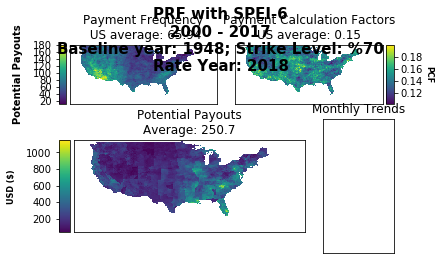

In [9]:
"""
Created on Fri Nov 17 22:19:03 2017

This script allows you to change parameters and call the functions. The working directory is set in the functions script while this is being tinkered with. 
    
    
*** To check rain-index outputs for accuracy set the baseline years from 1948 to 2016 and check the matching outputs from this site:
    
    https://prodwebnlb.rma.usda.gov/apps/prf#
    
@author: Travis
"""
%matplotlib inline
#runfile('C:/Users/Travis/GitHub/Pasture-Rangeland-Forage/functions-git.py', wdir='C:/Users/Travis/GitHub/Pasture-Rangeland-Forage')
import warnings
warnings.filterwarnings("ignore")

############################ Normal NOAA Method ###############################
#rasterpath = "e:\\data\\droughtindices\\noaa\\nad83\\raw"
##rasterpath = "f:\\data\\droughtindices\\noaa\\nad83\\raw"
#method = 1 # Method 1 is the present way of calculating triggers and magnitudes
#adjustit = False
#standardizeit = False
#indexit = True

####################### Test methods for drought indices ######################
#rasterpath = r'e:\data\droughtindices\palmer\pdsi\nad83'
rasterpath = r'f:\data\droughtindices\spei\nad83\6month'
#rasterpath = r'E:\data\droughtindices\grace\nad83\rz\monthly\quarteres'
method = 2 # method 2 set strike levels based on matching probability of occurrence with the RMA index
adjustit = True
standardizeit = True
indexit = False

############### Argument Definitions ##########################################
actuarialyear = 2018 
baselineyear = 1948
baselinendyear = 2016   
startyear = 2000
endyear = 2017
productivity = 1 
strike = .7
acres = 500
allocation = .5
difference = 0 # 0 = indemnities, 1 = net payouts, 2 = lossratios 


#################### Function Call #################################################################
[insurance_package_all, insurance_package_average, index_package_all,index_package,cid,coords] = indexInsurance(rasterpath, actuarialyear, startyear,endyear, baselineyear,baselinendyear, productivity, strike, acres, allocation, adjustit = adjustit,standardizeit = standardizeit, indexit = indexit, method = method, difference = difference) 

# Return order:
#insurance_package_all = [producerpremiums,indemnities]
#insurance_package_average = [meanppremium,meanindemnity]
#index_package_all = [frequencyrays,pcfrays]
#index_package = [frequencysum,meanpcf]